### **Study Buddy AI: Your Personalized Study Assistant**  
<!-- ##### **Description:**  
Study Buddy AI is an intelligent assistant designed to revolutionize the way students learn and plan their studies. Equipped with advanced features like personalized study plans, web search for research, math problem-solving, and human-in-the-loop assistance, it ensures accurate, actionable, and tailored support for academic success. Leveraging memory and contextual knowledge, Study Buddy AI creates dynamic, efficient schedules and provides step-by-step explanations to help students master any subject with ease. -->
##### **Current Features:**  
- **Tool Assistance**: Integrates with tools like Study Scheduler and Web Search.
- **Personalized Support**: Remembers user-specific details such as exam dates, preferred study times, and past topics to deliver customized responses.
- **Study Schedule Creation**: Automatically generates optimized study plans based on deadlines, topics, and available time.
- **User-Friendly Interaction**: Polite, clear, and concise responses with follow-up questions to ensure clarity.

### DEPENDCIES


In [1274]:
%pip install -q -U google-generativeai langchain-google-genai langgraph langchain langchain-core pydantic tavily-python langchain_community

^C
Note: you may need to restart the kernel to use updated packages.


In [1391]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GOOGLE_API_KEY")
_set_env("TAVILY_API_KEY")
# _set_env("LANGCHAIN_API_KEY")
# _set_env("LANGCHAIN_PROJECT")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [1392]:
from typing import TypedDict, Optional, List, Annotated, Any, Dict, Union
from pydantic import BaseModel
import csv
import uuid
import json
from datetime import datetime, timedelta

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_community.tools.tavily_search import TavilySearchResults

from langchain.prompts import ChatPromptTemplate, PromptTemplate, MessagesPlaceholder
from langchain.output_parsers import PydanticOutputParser

from langchain_core.tools import tool, InjectedToolArg
from langchain_core.runnables.config import RunnableConfig
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    SystemMessage,
    HumanMessage,
    AIMessage,
    AnyMessage,
    RemoveMessage,
)

from IPython.display import Image

### STATES


In [1393]:
class InputState(TypedDict):
    query: str


class OutputState(TypedDict):
    response: AIMessage


class OverallState(InputState, OutputState):
    messages: Annotated[List[AnyMessage], add_messages]
    summary: Optional[str] = None
    memories: Optional[str] = None

### PERSISTANCE

In [1394]:
checkpointer = MemorySaver()

### MODELS


In [1395]:
# MODEL_NAME = "gemini-2.0-flash-exp"
MODEL_NAME = "gemini-1.5-flash"
EMBEDDING_MODEL_NAME = "models/embedding-001"

model = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)
embedding_model = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL_NAME)

### MEMORY

#### In Memory Store


In [1396]:
in_memory_store = InMemoryStore(
    index={
        "embed": embedding_model,
        "dims": 1536,
    }
)

#### Memory Namespace


In [1397]:
NAMESPACE_NAME = "memories"

# We would generally get the user_id from the authenticated User
user_id = uuid.uuid4()

#### Memory Type


In [1398]:
class ReminderType(TypedDict):
    """
    Defines the structure of a reminder with a description and a date.
    Each reminder includes a description of the event and the date when it should occur.
    """
    description: Optional[str] = None # A short description of the reminder (e.g., "Study session" or "Exam")
    date: Optional[str] = None # The date of the reminder in "YYYY-MM-DD" format (e.g., "2024-12-15")


class ProgressType(TypedDict):
    """
    Defines the structure of progress for a study topic as a percentage.
    Each progress entry includes the topic name and its completion percentage.
    """
    topic: Optional[str] = None  # The name of the study topic (e.g., "Algebra")
    progress_percentage: Optional[float] = None  # The completion percentage for the topic (e.g., 75.0)


class MemoryType(TypedDict):
    """
    General memory structure for a Study Buddy Agent to store study preferences,
    reminders, deadlines, progress, and personal notes.
    """
    # User Information (Tracking user-specific details)
    username: Optional[str] = None
    """The username of the user (e.g., "john_doe")"""

    age: Optional[int] = None
    """The age of the user (e.g., 21)"""

    gender: Optional[str] = None
    """The gender of the user (e.g., "Male", "Female", "Non-binary")"""

    preferences: Optional[str] = None
    """User preferences, such as preferred study time, study methods, etc."""

    # Study Preferences
    study_duration: Optional[int] = None
    """Preferred study duration in minutes (e.g., 60 minutes)"""

    break_duration: Optional[int] = None
    """Preferred break duration in minutes (e.g., 15 minutes)"""

    # Scheduling and Deadlines
    reminders: List[ReminderType] = []
    """List of reminders with descriptions and dates (e.g., [{"description": "Study for Math exam", "date": "2024-12-15"}])"""

    deadlines: List[ReminderType] = []
    """List of deadlines with event names and corresponding dates (e.g., [{"description": "Assignment deadline", "date": "2024-12-18"}])"""

    # Study Topics
    topics_to_study: List[str] = []
    """List of topics to study (e.g., ["Algebra", "History"])"""

    completed_topics: List[str] = []
    """List of topics that have been completed (e.g., ["Calculus", "Literature"])"""

    # Progress Tracking
    progress: List[ProgressType] = []
    """Progress for each study topic as a percentage (e.g., [{"topic": "Algebra", "progress_percentage": 75.0}])"""

    # Personal Notes and Goals
    personal_notes: Optional[str] = None
    """Space for personal goals, motivational notes, or other reminders"""

    # Last Updated Timestamp
    last_updated: Optional[str] = None
    """Timestamp for when the memory was last updated (e.g., "2024-12-15T14:30:00")"""

### TOOLS


#### Web Search Tools


In [1399]:
tavily_search_tool = TavilySearchResults(
    name="tavily_web_search",
    max_results=5,
    # include_answer=True,
    # include_raw_content=True,
    # include_images=True,
)

#### Study Scheduling Tools


In [1400]:
# class DeadlineType(TypedDict):
#     """
#     Represents a deadline associated with a subject.
#     """

#     subject: Optional[str]  # The subject for which the deadline applies (e.g., "Math")
#     deadline_date:Optional[str]  # The date of the deadline in "YYYY-MM-DD" format (e.g., "2024-12-15")
    

class StudySession(TypedDict):
    """
    Represents a study session with details about the subject, time, notes.
    """

    day: str  # The day of the week for the study session (e.g., "Monday")
    subject: str  # The subject being studied (e.g., "Math")
    start_time: str  # Start time of the session in "HH:MM" format (e.g., "09:00")
    end_time: str  # End time of the session in "HH:MM" format (e.g., "11:00")
    notes: str  # Additional notes for the session (e.g., "Focus on Algebra")
    priority: str  # Priority of the study session (e.g., "High", "Medium", "Low")
    estimated_completion_time: (
        int  # Estimated time for completion of the subject in minutes
    )
    study_type: str  # Type of study session (e.g., "Focused", "Review")
    status: str  # Completion status (e.g., "Completed", "Pending")
    study_notes: Optional[
        str
    ]  # Specific study notes for the session (e.g., "Focus on chapters 3-5")
    available_time_per_day: int  # Total study time available per day in minutes
    # deadlines: DeadlineType


@tool
def create_study_schedule(
    study_sessions: List[StudySession],  # List of StudySession dictionaries
) -> List[StudySession]:
    """
    Creates a personalized study schedule based on user preferences, subjects, and available time.

    This function takes a list of study sessions, calculates the required time for each, and creates a study
    schedule based on the available time per day. It also ensures that the number of sessions does not exceed
    the available time, provides a break between consecutive study sessions, and includes warnings when the
    available time is insufficient for all sessions.

    Args:
        study_sessions (List[StudySession]): A list of dictionaries, each representing a study session. Each dictionary must contain the following keys:
            - 'day': The day of the week for the study session (e.g., "Monday").
            - 'subject': The subject being studied (e.g., "Math").
            - 'start_time': The start time of the session in "HH:MM" format.
            - 'end_time': The end time of the session in "HH:MM" format.
            - 'notes': Additional notes for the session (e.g., "Focus on Algebra").
            - 'priority': The priority of the session (e.g., "High", "Medium", "Low").
            - 'estimated_completion_time': The estimated duration for completing
            the session in minutes.
            - 'study_type': The type of session (e.g., "Focused", "Review").
            - 'status': The completion status of the session (e.g., "Completed", "Pending").
            - 'study_notes': Specific study notes for the session (optional).
            - 'available_time_per_day': The total study time available per day in minutes.

    Returns:
        List[StudySession]: A list of dictionaries representing the generated study schedule. Each dictionary contains the following keys:
            - 'day': The day of the week for the study session.
            - 'subject': The subject being studied.
            - 'start_time': The start time of the session in "HH:MM" format.
            - 'end_time': The end time of the session in "HH:MM" format.
            - 'notes': Additional notes for the session.
            - 'priority': The priority of the session.
            - 'estimated_completion_time': The estimated duration for completing the session.
            - 'study_type': The type of session.
            - 'status': The completion status of the session.
            - 'study_notes': Specific study notes for the session.
            - 'available_time_per_day': The total study time available per day.
            - Breaks: A break is included after each session unless it’s the last session.

    Warnings:
        - If the total time for all sessions exceeds the available time per day, the function will try to fit as many sessions as possible.
        - If there is remaining time after scheduling, a message will be shown to inform the user.
    """

    schedule = []
    current_day = datetime.now()

    total_sessions = len(study_sessions)

    for i, session in enumerate(study_sessions):
        available_time_per_day = session["available_time_per_day"]

        # Calculate the total time required for all study sessions
        total_session_time = session["estimated_completion_time"]
        max_sessions_per_day = available_time_per_day // total_session_time

        # # If more sessions exist than can fit into the available time, we generate a warning
        # if total_sessions > max_sessions_per_day:
        #     print(
        #         f"Warning: Only {max_sessions_per_day} study sessions can fit into the available time per day."
        #     )

        # Calculate remaining time for the day
        remaining_time = available_time_per_day - (total_sessions * total_session_time)

        # Loop through each study session to allocate time slots
        for i, study_session in enumerate(study_sessions):
            # Calculate start time and end time for each session
            start_time = current_day.replace(hour=9, minute=0) + timedelta(days=i)
            end_time = start_time + timedelta(
                minutes=study_session["estimated_completion_time"]
            )

            # Create the study session entry
            schedule.append(
                StudySession(
                    day=start_time.strftime("%A"),
                    subject=study_session["subject"],
                    start_time=start_time.strftime("%H:%M"),
                    end_time=end_time.strftime("%H:%M"),
                    notes=study_session["notes"],
                    priority=study_session["priority"],
                    estimated_completion_time=study_session[
                        "estimated_completion_time"
                    ],
                    study_type=study_session["study_type"],
                    status=study_session["status"],
                    study_notes=(
                        study_session["study_notes"]
                        if "study_notes" in study_session
                        else ""
                    ),
                    available_time_per_day=study_session["available_time_per_day"],
                )
            )

            # If this is not the last session, add a break
            if i < len(study_sessions) - 1:
                break_time_start = end_time
                break_time_end = break_time_start + timedelta(
                    minutes=15
                )  # Assuming a 15-minute break
                schedule.append(
                    StudySession(
                        day=start_time.strftime("%A"),
                        subject="Break",
                        start_time=break_time_start.strftime("%H:%M"),
                        end_time=break_time_end.strftime("%H:%M"),
                        notes="Break",
                        priority="Low",
                        estimated_completion_time=15,
                        study_type="Break",
                        status="Pending",
                        study_notes="",
                        available_time_per_day=study_session["available_time_per_day"],
                    )
                )

        # Inform the user about any remaining time
        # if remaining_time > 0:
        #     print(f"Remaining time after schedule: {remaining_time} minutes.")

    return schedule


@tool
def save_study_schedule_to_markdown(
    markdown: str, file_name: str = "study_schedule.md"
) -> str:
    """
    Saves the study schedule content into a Markdown file, ensuring proper line breaks and formatting.

    Args:
        markdown (str): The content in Markdown format to be saved.
        file_name (str): The name of the Markdown file where the schedule will be saved (default is 'study_schedule.md').

    Returns:
        str: Success Messages
    """
    try:
        # Ensure line breaks are properly handled and formatting is correct
        formatted_markdown = markdown.replace("\\n", "\n")  # Ensure proper line breaks

        # Open the file in write mode and save the Markdown content
        with open(file_name, mode="w") as file:
            file.write(formatted_markdown)
        return f"Study schedule saved successfully to {file_name}"

    except PermissionError:
        print(f"Error: Permission denied when trying to write to {file_name}.")
    except FileNotFoundError:
        print(f"Error: Directory or file path {file_name} not found.")
    except Exception as e:
        print(f"Error saving study schedule: {e}")


@tool
def save_study_schedule_to_csv(
    schedule_data: List[StudySession],
    file_name: str = "study_schedule.csv",
    field_names: List[str] = [
        "day",
        "subject",
        "start_time",
        "end_time",
        "notes",
        "priority",
        "estimated_completion_time",
        "study_type",
        "status",
        "study_notes",
        "available_time_per_day",
    ],
) -> str:
    """
    Saves the study schedule to a CSV file.

    Args:
        schedule_data (List[StudySession]): A list of study sessions to be saved.
        file_name (str): The name of the CSV file where the schedule will be saved (default is 'study_schedule.csv').
        field_names (List[str]): The column names for the CSV file (default is ["day", "subject", "start_time", "end_time", "notes"]).

    Returns:
        str: Success Messages
    """

    # Dynamically fetch required keys from StudySession TypedDict
    required_keys = set(StudySession.__annotations__.keys())  # Set of required keys

    for session in schedule_data:
        if not required_keys.issubset(session.keys()):
            raise ValueError(
                f"Each schedule entry must contain the following keys: {', '.join(required_keys)}"
            )

    try:
        with open(file_name, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=field_names)
            writer.writeheader()

            # Handling falsy or empty values for any field in the session
            for session in schedule_data:
                session_dict = (
                    session.copy()
                )  # Create a copy of the session to avoid modifying the original

                # Iterate through each field and handle falsy or empty values
                for key, value in session_dict.items():
                    if value in (None, "", [], {}, 0, False):  # Check for falsy values
                        if key == "study_notes":
                            session_dict[key] = (
                                ""  # Empty study_notes should be an empty string
                            )
                        else:
                            session_dict[key] = (
                                "N/A"  # Default for other fields (e.g., "N/A" or 0)
                            )

                # Write the session row
                writer.writerow(session_dict)

        return f"Study schedule saved successfully to {file_name}"
    except PermissionError:
        print(f"Error: Permission denied when trying to write to {file_name}.")
    except FileNotFoundError:
        print(f"Error: File {file_name} not found.")
    except Exception as e:
        print(f"Error saving study schedule: {e}")

#### Memory Tools (Currently Not Using This)

In [1401]:
from pydantic import ConfigDict

class UpsertMemoryInput(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)

    memory: MemoryType
    memory_id: Optional[Union[uuid.UUID, str]]
    memory_type: Optional[str]
    store: Annotated[BaseStore, InjectedToolArg]


@tool(args_schema=UpsertMemoryInput)
def upsert_memory(
    memory: MemoryType,
    memory_id: Optional[Union[uuid.UUID, str]],
    memory_type: Optional[str],
    store,
):
    """
    Store or update a generalized memory for the Study Buddy Agent in the database.

    Args:
        memory (MemoryType): The memory dictionary must contain the following keys:
            - `username` (Optional[str], optional): The username of the user (e.g., "john_doe").
            - `age` (Optional[int], optional): The age of the user (e.g., 21).
            - `gender` (Optional[str], optional): The gender of the user (e.g., "Male", "Female", "Non-binary").
            - `preferences` (Optional[str], optional): User preferences, such as preferred study time, study methods, etc.
            - `study_duration` (Optional[int], optional): Preferred study duration in minutes (e.g., 60 minutes).
            - `break_duration` (Optional[int], optional): Preferred break duration in minutes (e.g., 15 minutes).
            - `reminders` (List[ReminderType], optional): A list of reminders, where each reminder is a dictionary containing:
                - `description` (Optional[str], optional): A short description of the reminder (e.g., "Study for Math exam").
                - `date` (Optional[str], optional): The date of the reminder in "YYYY-MM-DD" format (e.g., "2024-12-15").
            - `deadlines` (List[ReminderType], optional): A list of deadlines, each defined by a `description` and `date`, similar to reminders.
            - `topics_to_study` (List[str], optional): A list of study topics the user needs to cover (e.g., ["Algebra", "History"]).
            - `completed_topics` (List[str], optional): A list of study topics that have already been completed (e.g., ["Calculus", "Literature"]).
            - `progress` (List[ProgressType], optional): A list of progress entries, where each entry includes:
                - `topic` (Optional[str], optional): The name of the study topic (e.g., "Algebra").
                - `progress_percentage` (Optional[float], optional): The completion percentage for the topic (e.g., 75.0).
            - `personal_notes` (Optional[str], optional): Space for personal notes, motivational goals, or other user-specific information.
            - `last_updated` (Optional[datetime], optional): A timestamp of when the memory was last updated (e.g., "2024-12-15T14:30:00").

        memory_id (Optional[Union[uuid.UUID, str]], optional): The ID of the memory to update. If not provided, a new ID will be generated. This is used to uniquely identify an existing memory entry that needs to be updated.
        memory_type (Optional[str], optional): The type of memory, used to categorize the memory. Examples include:
            - "study_preferences" for user-specific study habits (e.g., preferred study time, break duration).
            - "exam_schedule" for tracking exam dates and related reminders.
            - "progress_tracking" for tracking progress on different study topics.
            - "personal_notes" for storing motivational notes or goals.
        
    Returns:
        str: A message confirming that the memory has been stored or updated, including the memory ID and memory type.
    """


    # Validate memory structure (TypedDict structure is already defined)
    if not memory:
        return "Error: Invalid memory format. Memory data cannot be empty."

    # Generate or use existing memory ID
    mem_id = memory_id or uuid.uuid4()

    # Ensure memory_type is provided or categorized, defaults to 'general'
    mem_type = memory_type or "general"

    # Retrieve user_id from the config
    # user_id = config["configurable"].get("user_id")
    if not user_id:
        return "Error: No user ID found in the configuration."

    try:
        # Store or update memory in the database
        store.put(
            (user_id, NAMESPACE_NAME),
            key=str(mem_id),
            value={  # Store memory with its type
                "memory_type": mem_type,
                "memory_data": memory,
            },
        )
        return f"Memory of type '{mem_type}' stored with ID {mem_id}."

    except Exception as e:
        print(e)
        # Return an error message if something goes wrong
        return f"Error: Failed to store memory. Please try again later."



@tool
def delete_memory(
    memory_id: uuid.UUID | str,
    config: RunnableConfig,
    store: Annotated[BaseStore, InjectedToolArg],
) -> str:
    """
    Delete a memory from the database by its ID.
    This function removes a specific memory from the store based on the provided
    memory ID. The memory ID must exist in the store for the deletion to be successful.

    Args:
        memory_id (uuid.UUID | str): The ID of the memory to delete.

    Returns:
        str: A message confirming whether the memory was successfully deleted or if the memory ID was not found.
    """


    user_id = config["configurable"].get("user_id")
    memory_key = str(memory_id)

    # Check if the memory exists before deleting
    memory = store.get((user_id, NAMESPACE_NAME), key=memory_key)

    if memory:
        store.delete((user_id, NAMESPACE_NAME), key=memory_key)
        return f"Memory {memory_id} successfully deleted."
    else:
        return f"Memory {memory_id} not found."

#### All Available Tools


In [1402]:
tools = [
    tavily_search_tool,
    create_study_schedule,
    save_study_schedule_to_csv,
    save_study_schedule_to_markdown,
    # upsert_memory,
    # delete_memory,
]

model_with_tools = model.bind_tools(tools=tools)

### UTILS


In [1403]:
def invoke_chat_template(
    model: BaseChatModel,
    template: str,
    template_data: dict[str, Any],
) -> BaseMessage:
    """Invoke the chat template with the provided tenplate data and return the response."""
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model
    result = chain.invoke(template_data)
    return result

### NODES


#### Tool Node


In [1404]:
# Tool Node
tool_node = ToolNode(tools)

#### Memory Nodes


In [1405]:
def get_memory_node(
    state: InputState,
    config: RunnableConfig,
    store: BaseStore,
) -> OverallState:
    """Retrieve memories associated with a user based on a query."""
    user_id = config["configurable"].get("user_id")

    items = store.search((user_id, "memories"), query=state["query"], limit=10)
    info = "\n".join([json.dumps(d.value) for d in items])

    memories = f"<memories>\n{info if info else ""}\n<memories>"

    return {"memories": memories}


class ParsedMemory(BaseModel):
    memory_id: Optional[str] = None
    memory_type: Optional[str] = None
    memory: MemoryType


def update_memory_node(
    state: OverallState,
    config: RunnableConfig,
    store: BaseStore,
) -> OverallState:
    summary = state.get("summary", "")
    memories = state.get("memories", "")
    user_query = state.get("query", "")
    history = summary if summary else state.get("messages", [])

    user_id = config["configurable"].get("user_id")
    namespace = (str(user_id), NAMESPACE_NAME)

    parser = PydanticOutputParser(pydantic_object=ParsedMemory)

    # Create our memories prompt
    memories_message = ChatPromptTemplate.from_template(
        "This is the current user's memory namespace: {namespace}\n\n"
        "This is summary or history of the conversation to date: {history}\n\n"
        "This is the latest user query: {user_query}\n\n"
        "These are the memories of the user based on the latest query: {memories}\n\n"
        "If the memories are available always first try to update instead and for updating always return the memory id"
        "Now based on the above if you think that the current memories should be updated or a new memory should be added then return the new or updated memory in the following Format:"
        """
        {format_instructions}
        """
        "EXAMPLES:"
        " - Creating a New Memory:"
        """
        {{
          "memory_type" : "general",
          "memory": {{
            "name": "<username>",
            "preferences": "likes to take half hour breaks",
            ...other_fields
          }}
        }}
        """
        " - Updating a Memory:"
        """
        {{
          "memory_id": "...",
          "memory": {{
            "preferences": "Now likes to take 1 hour breaks",
            ...other_fields
          }}
        }}
        """
    ).format(
        format_instructions=parser.get_format_instructions(),
        history=history,
        memories=memories,
        user_query=user_query,
        namespace=str(namespace),
    )

    response = model.invoke(memories_message)

    parsed_response = parser.parse(response.content)

    mem_id = parsed_response.memory_id or uuid.uuid4()
    mem_type = parsed_response.memory_type or "general"
    store.put(
        namespace,
        key=str(mem_id),
        value={  # Store memory with its type
            "memory_type": str(mem_type),
            "memory_data": parsed_response.model_dump().get("memory"),
        },
    )

    return {"memories": state.get("memories")}

#### Handle User Query Node

In [1406]:
system_prompt = ChatPromptTemplate.from_template(
    """
You are Study Buddy AI, an intelligent assistant designed to help students with their study plans, research, and problem-solving tasks. Your core capabilities include:

1. **Tool Assistance**: Use external tools like Study Scheduler, math solvers, calendar APIs, Web Search, and knowledge bases to provide accurate and actionable solutions.
1. **Web Search**: Use external tools Tavily Web Search to find reference materials for user.
2. **Human-in-the-Loop (HITL)**: If a task is too complex or ambiguous, escalate the query to a human assistant for intervention.
3. **Personalized Support**: Leverage user memory to provide tailored responses, such as recalling exam dates, preferred study times, and previous topics.
4. **Agentic RAG**: Retrieve contextually relevant information from a knowledge base for accurate and concise answers.

### Behavior Guidelines:
- Be polite, clear, and concise in your responses.
- Always ensure accuracy and ask follow-up questions if needed.
- Provide explanations and educational insights whenever possible.

### Requirements:
- If the query involves planning (e.g., study schedules), ask for specific details like deadlines, topics, and available time.
  If the user does not have any specific requirements, use your expertise and auto-create a schedule for them.
- When solving problems, provide step-by-step explanations.
- For ambiguous or complex questions, pause and notify the user about involving a human assistant.
- If available Use the user's context and memory to personalize responses effectively.

### SUMMARY
{summary}

### MEMORIES
{memories}

### EXAMPLES:

#### Human: "What is Langgraph?"
- Tool Call: Use Tools to search the web and get content.
- AI: "Langgraph is an agentic AI framework... "

#### Human: "Plan a study schedule for me for Python test on Friday."
- AI: "What topics need to be covered? How many hours per day can you dedicate to studying? Do you want me to include break times?"
- Human: "All of the main Python topics need to be covered. The rest of the data you can fill in yourself."
- Tool Call: Used Study Scheduler Tool to create a schedule.
- AI: "Ok, since this is a Python test, I have created a schedule optimized for studying this type of test."

#### Human: "Explain trigonometric identities."
- AI: "Trigonometric identities are equations involving trigonometric functions that hold true for all variable values. Would you like a video link or a written example?"

#### Human: "Solve this integration problem."
- AI: "Let me analyze this using a math tool. If it’s too complex, I’ll involve a human assistant."
"""
)



def handle_user_query_node(state: InputState | OverallState) -> OverallState:
    """
    Calls the model with the correct input state, integrating all messages (including tool calls and prior responses)
    to ensure the model has the full context.
    """

    # Retrieve the conversation history and user query
    messages = state.get("messages", [])
    user_query = state.get("query", "")
    summary = state.get("summary", "")
    memories = state.get("memories", "")

    # Construct the system message with the summary and memories (if available)
    system_message = SystemMessage(
        content=system_prompt.format(
            summary=summary,  # Include summary context if available
            memories=memories,  # Include memory context if available
        )
    )

    # Combine system message, prior tool messages, and the current user query
    # Ensure all relevant messages are included in the context
    all_messages = [system_message] + messages + [HumanMessage(content=user_query)]

    # Call the model with the full message history (system message, tool messages, and user query)
    result = model_with_tools.invoke(all_messages)

    # Return the result as a response
    return {"messages": [result]}

#### Summarization Node


In [1407]:
def summarization_node(state: OverallState) -> OverallState:
    # First, we get any existing summary
    summary = state.get("summary")
    messages = state.get("messages")

    # Create our summarization prompt
    if summary:
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = messages[:-4] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages: list = []
    if len(delete_messages) > 6:
        # Delete all but the 2 most recent messages
        delete_messages = [RemoveMessage(id=m.id or "") for m in messages[:-2]]

    return {"summary": response.content, "messages": delete_messages}

#### Output Node


In [1408]:
def output_node(state: OverallState) -> OutputState:
    return {"response": state["messages"][-1]}

### AGENT COMPILATION


In [1411]:
# Create the graph
workflow = StateGraph(OverallState, input=InputState, output=OutputState)

# Add nodes
workflow.add_node("handle_user_query", handle_user_query_node)
workflow.add_node("get_memory", get_memory_node)
workflow.add_node("tools", tool_node)
workflow.add_node("summarization", summarization_node)
workflow.add_node("finalize_output", output_node)
workflow.add_node("update_memory", update_memory_node)

# Add edges
workflow.add_edge(START, "get_memory")
workflow.add_edge("get_memory", "handle_user_query")
workflow.add_conditional_edges(
    "handle_user_query", tools_condition, {"tools": "tools", END: END}
)
workflow.add_edge("tools", "handle_user_query")
workflow.add_edge("handle_user_query", "summarization")
workflow.add_edge("summarization", "update_memory")
workflow.add_edge("update_memory", "finalize_output")
workflow.add_edge("finalize_output", END)

# Compile the graph
agent = workflow.compile(checkpointer=checkpointer, store=in_memory_store)

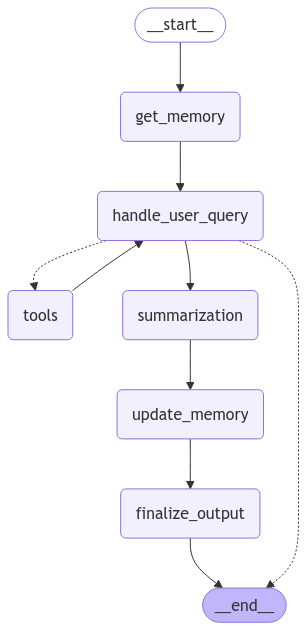

In [1412]:
Image(agent.get_graph().draw_mermaid_png())

### TESTING SCENARIOIS

#### NEED REFERENCE MATERIALS FOR LEARNING?

In [1413]:
config = {"configurable": {"thread_id": "1", "user_id": str(user_id)}}

In [1414]:
result = agent.invoke(
    input={
        "query": "Hi, I am trying to Learn Langgraph, can you please find some reference material for me to get Started?"
    },
    config=config,
 
)

result.get("response").pretty_print()

================================== Ai Message ==================================

LangGraph is a framework for building and deploying language agents as graphs.  I found several resources that may help you get started:

* **LangChain LangGraph Tutorials:** This provides notebooks to help you create chatbots, RAGs, SQL agents, planning agents, and more. [https://langchain-ai.github.io/langgraph/tutorials/](https://langchain-ai.github.io/langgraph/tutorials/)

* **LangChain LangGraph Documentation:** This explains LangGraph as a framework for building and scaling agentic applications with LangChain Platform.  It covers control flows, human-agent collaboration, streaming, and deployment options. [https://www.langchain.com/langgraph](https://www.langchain.com/langgraph)

* **LangGraph Platform Documentation:** This describes the commercial solution for deploying agentic applications to production, built on the open-source LangGraph framework.  It details the server API and architecture. [h

#### TESTING PERSISTANCE

In [1428]:
config = {"configurable": {"thread_id": "1", "user_id": str(user_id)}}

In [1429]:
result = agent.invoke(
    input={
        "query": "Please Tell me what i said before"
    },
    config=config,
 
)

result.get("response").pretty_print()

================================== Ai Message ==================================

Our previous conversation started with your question about LangGraph.  You asked, "What is Langgraph?".  I then responded by providing information about LangGraph based on a web search, including links to relevant documentation and tutorials.


#### TESTING MEMORY

In [1424]:
config = {"configurable": {"thread_id": "2", "user_id": str(user_id)}}

In [1425]:
result = agent.invoke(
    input={
        "query": "Hi, I am Moosa and i love langgraph"
    },
    config=config,
 
)

result.get("response").pretty_print()

================================== Ai Message ==================================

Hi Moosa!  It's great to hear from you again. I see from your profile that you're interested in LangGraph and Python. Is there anything specific you'd like to work on today, such as creating a study plan, researching a particular LangGraph concept, or practicing some Python code?


In [1426]:
config = {"configurable": {"thread_id": "111", "user_id": str(user_id)}}

In [1427]:
result = agent.invoke(
    input={
        "query": "What is my Name?"
    },
    config=config,
 
)

result.get("response").pretty_print()

================================== Ai Message ==================================

Your name is Moosa.


#### CREATING STUDY SCHEDULE

In [1419]:
config = {"configurable": {"thread_id": "2", "user_id": str(user_id)}}

In [1420]:
result = agent.invoke(
    input={
        "query": "Hi, I Like python very much and have a python test upcoming on friday, please create a study schedule for me"
    },
    config=config,
 
)

result.get("response").pretty_print()

================================== Ai Message ==================================

Okay, Moosa. I can help you create a study schedule for your Python test on Friday. To make the schedule as effective as possible, I need some more information:

1. **What topics in Python need to be covered for the test?**  (e.g., data structures, functions, object-oriented programming, etc.)  The more detail you provide, the better I can tailor the schedule.
2. **How many hours per day can you dedicate to studying?**
3. **Do you prefer to study in shorter, more frequent sessions or longer, less frequent sessions?**
4. **Do you want to include breaks in the schedule?** If so, how long should the breaks be?


Once I have this information, I can generate a personalized study schedule for you.


In [1421]:
result = agent.invoke(
    input={
        "query": "The test is about all major topics of python, please fill the rest of the information which you think is best for studying for this python test"
    },
    config=config,
)

result.get("response").pretty_print()

================================== Ai Message ==================================

Okay, Moosa. Since you'll be tested on all major Python topics and haven't specified your daily study time or session preferences, I'll create a sample schedule assuming you can dedicate around 3 hours per day and prefer shorter study sessions with breaks.  This schedule is adjustable, of course, based on your actual availability and learning style.

I'll assume the major Python topics include:

* Data Types and Operators
* Control Flow (if/else, loops)
* Functions
* Data Structures (lists, tuples, dictionaries, sets)
* Object-Oriented Programming (classes, objects, inheritance)
* File Handling
* Modules and Packages
* Exception Handling


Here's a possible study schedule:


**Day 1:**

* **9:00 AM - 10:00 AM:** Data Types and Operators (Review basic concepts, practice exercises)
* **10:00 AM - 10:15 AM:** Break
* **10:15 AM - 11:15 AM:** Control Flow (Practice different loop types and conditional stateme

In [1422]:
result = agent.invoke(
    input={
        "query": "Thats Great! Please save the schedule in both csv and markdown files"
    },
    config=config,
)

result.get("response").pretty_print()

================================== Ai Message ==================================

I have saved the study schedule to both `study_schedule.csv` and `study_schedule.md` files.  Let me know if you have any other questions or would like me to adjust the schedule.
